In [1]:
import pandas as pd

/home/jaeyeonl/.local/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import glob

In [3]:
# from bin.consol.utils import load_dataset
# # import bin

# gsmdf = load_dataset('gsm')
gsmdf = pd.read_json('./resources/data/gsm.jsonl', lines=True)
gsmdf

,input,target
0,Janet’s ducks lay 16 eggs per day. She eats th...,18
1,A robe takes 2 bolts of blue fiber and half th...,3
2,Josh decides to try flipping a house. He buys...,70000
3,James decides to run 3 sprints 3 times a week....,540
4,"Every day, Wendi feeds each of her chickens th...",20
...,...,...
1314,John had a son James when he was 19. James is...,8
1315,There are some oranges in a basket. Ana spends...,5
1316,Mark's car breaks down and he needs to get a n...,230
1317,"Farmer Brown has 20 animals on his farm, all e...",5


In [4]:
def get_model_problem_summary(globpath, n=40):
    df = pd.concat([pd.read_csv(filepath, index_col=0).head(n).assign(id=int(filepath.split("/")[-1].split('.')[0])) for filepath in sorted(glob.glob(globpath))]).reset_index(drop=True)
    df2 = gsmdf.target.to_frame()
    df2['answer'] = df.groupby('id').answer.agg(lambda x: x.value_counts().index[0])
    df2['trials'] = df.groupby('id').token_usage.count()
    df2['token_usage'] = df.groupby('id').token_usage.sum()
    return df2

def get_model_summary(df):
    return pd.Series({
        "mean_token_usage": df.token_usage.mean(),
        "estimated_price": df.token_usage.sum() * 0.60 / 1e6,
        "accuracy": (df.target == df.answer).mean(),
    })

get_model_summary(get_model_problem_summary("resources/gsm/gpt4omini-gsm-vote/*"))

mean_token_usage    5314.360395
estimated_price        4.202596
accuracy               0.941622
dtype: float64

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", palette="pastel")


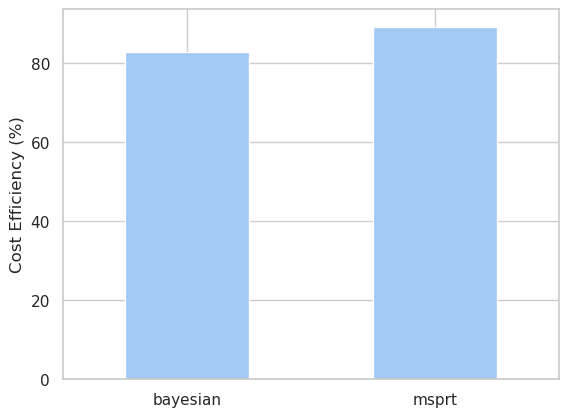

In [6]:
ax = (100 - 100*pd.Series([
    get_model_summary(get_model_problem_summary("resources/gsm/gpt4omini-gsm-bayesian/*", n=40)).mean_token_usage / get_model_summary(get_model_problem_summary("resources/gsm/gpt4omini-gsm-vote/*", n=40)).mean_token_usage,
    get_model_summary(get_model_problem_summary("resources/gsm/gpt4omini-gsm-msprt-25600509446/*", n=256)).mean_token_usage / get_model_summary(get_model_problem_summary("resources/gsm/gpt4omini-gsm-vote/*", n=40)).mean_token_usage,
    # get_model_summary(get_model_problem_summary("resources/o3minilow-aime24-bayesian/*", n=40)).mean_token_usage / get_model_summary(get_model_problem_summary("resources/o3minilow-aime24-vote/*", n=40)).mean_token_usage,
])).to_frame().assign(label=["bayesian", "msprt"]).set_index('label').plot.bar(ylabel="Cost Efficiency (%)", xlabel="", rot=0, legend=False)

# plt.savefig("cost_efficiency.pdf", bbox_inches='tight', dpi=300)

In [7]:
(
    get_model_summary(get_model_problem_summary("resources/gsm/gpt4omini-gsm-vote/*", n=1)),
    get_model_summary(get_model_problem_summary("resources/gsm/gpt4omini-gsm-msprt-25600509446/*", n=1)),

    get_model_summary(get_model_problem_summary("resources/gsm/gpt4omini-gsm-vote/*", n=40)),
    get_model_summary(get_model_problem_summary("resources/gsm/gpt4omini-gsm-msprt-25600509446/*", n=256)),
)

(mean_token_usage    132.238240
 estimated_price       0.104574
 accuracy              0.891585
 dtype: float64,
 mean_token_usage    131.519333
 estimated_price       0.104084
 accuracy              0.883245
 dtype: float64,
 mean_token_usage    5314.360395
 estimated_price        4.202596
 accuracy               0.941622
 dtype: float64,
 mean_token_usage    568.673237
 estimated_price       0.450048
 accuracy              0.936315
 dtype: float64)

In [8]:
(
    get_model_summary(get_model_problem_summary("resources/gsm/gpt4omini-gsm-vote/*", n=1)),
    get_model_summary(get_model_problem_summary("resources/gsm/gpt4omini-gsm-bayesian/*", n=1)),

    get_model_summary(get_model_problem_summary("resources/gsm/gpt4omini-gsm-vote/*", n=40)),
    get_model_summary(get_model_problem_summary("resources/gsm/gpt4omini-gsm-bayesian/*", n=40)),
)

(mean_token_usage    132.238240
 estimated_price       0.104574
 accuracy              0.891585
 dtype: float64,
 mean_token_usage    132.978772
 estimated_price       0.105239
 accuracy              0.884761
 dtype: float64,
 mean_token_usage    5314.360395
 estimated_price        4.202596
 accuracy               0.941622
 dtype: float64,
 mean_token_usage    911.278241
 estimated_price       0.721186
 accuracy              0.941622
 dtype: float64)

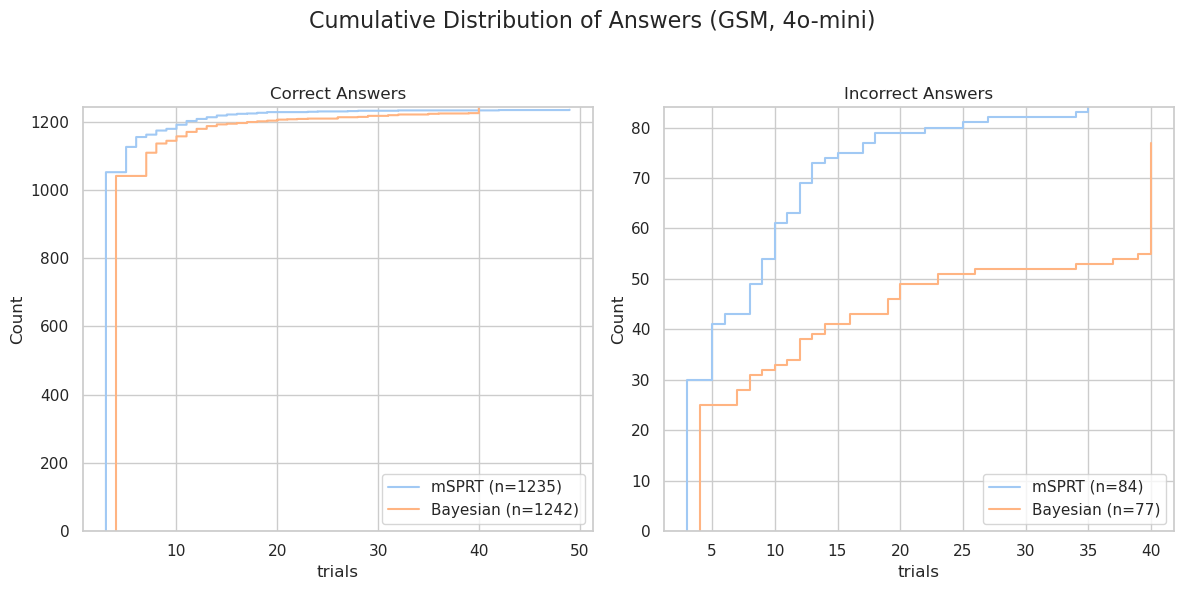

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Subplot Setup ---
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cumulative Distribution of Answers (GSM, 4o-mini)", fontsize=16)

# --- Correct Answers Subplot ---
# SPRT correct trials
df_msprt = get_model_problem_summary("resources/gsm/gpt4omini-gsm-msprt-25600509446/*", n=256)
correct_trials_msprt = df_msprt[df_msprt.target == df_msprt.answer].trials
sns.ecdfplot(data=correct_trials_msprt, 
             ax=ax1, 
             label=f"mSPRT (n={len(correct_trials_msprt)})", 
             linestyle="solid", 
             stat="count")

# Bayesian correct trials
df_bayes = get_model_problem_summary("resources/gsm/gpt4omini-gsm-bayesian/*", n=40)
correct_trials_bayes = df_bayes[df_bayes.target == df_bayes.answer].trials
sns.ecdfplot(data=correct_trials_bayes, 
             ax=ax1, 
             label=f"Bayesian (n={len(correct_trials_bayes)})", 
             linestyle="solid", 
             stat="count")

ax1.set_title("Correct Answers")
ax1.legend()

# --- Incorrect Answers Subplot ---
# SPRT incorrect trials
df_msprt = get_model_problem_summary("resources/gsm/gpt4omini-gsm-msprt-25600509446/*", n=256)
incorrect_trials_sprt = df_msprt[df_msprt.target != df_msprt.answer].trials
sns.ecdfplot(data=incorrect_trials_sprt, 
             ax=ax2, 
             label=f"mSPRT (n={len(incorrect_trials_sprt)})", 
             linestyle="solid", 
             stat="count")

# Bayesian incorrect trials
df_bayes = get_model_problem_summary("resources/gsm/gpt4omini-gsm-bayesian/*", n=40)
incorrect_trials_bayes = df_bayes[df_bayes.target != df_bayes.answer].trials
sns.ecdfplot(data=incorrect_trials_bayes, 
             ax=ax2, 
             label=f"Bayesian (n={len(incorrect_trials_bayes)})", 
             linestyle="solid", 
             stat="count")

ax2.set_title("Incorrect Answers")
ax2.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig("figures/cdist-4o-mini-GSM.pdf", dpi=300, bbox_inches='tight')
plt.show()